In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s4e10/sample_submission.csv
/kaggle/input/playground-series-s4e10/train.csv
/kaggle/input/playground-series-s4e10/test.csv


***MODULES***

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler 
from sklearn.model_selection import train_test_split 
import lightgbm as lgb 
from sklearn.metrics import roc_auc_score 

***LOADING THE DATASETS***

In [3]:
#submission path
subs = pd.read_csv('/kaggle/input/playground-series-s4e10/sample_submission.csv')
#training path
trn = pd.read_csv('/kaggle/input/playground-series-s4e10/train.csv')
#testing path
tst = pd.read_csv('/kaggle/input/playground-series-s4e10/test.csv')

class get_summary:
    def __init__(self, x):
        self.x = x
    def data_set(self):
        #checks for duplicate
        duplicate = self.x.duplicated().any()
        #drop duplicates 
        if duplicate == True:
            self.x.drop_duplicates(inplace=True)
            self.x.reset_index(drop=True)
        #checks for empty values
        null = self.x.isna().sum().any()
        #missing values
        total_missing = self.x.isnull().sum().sum()
        #data types
        data_type = self.x.dtypes
        #shape
        shapes = self.x.shape
        return f"Duplicate: {duplicate}\nNull: {null}\nMissing_value: {total_missing}\nTypes:\n{data_type}\nShape: {shapes}"
    
print(f"Training dataset:\n{get_summary(trn).data_set()}\nTest dataset:\n{get_summary(tst).data_set()}")

Training dataset:
Duplicate: False
Null: False
Missing_value: 0
Types:
id                              int64
person_age                      int64
person_income                   int64
person_home_ownership          object
person_emp_length             float64
loan_intent                    object
loan_grade                     object
loan_amnt                       int64
loan_int_rate                 float64
loan_percent_income           float64
cb_person_default_on_file      object
cb_person_cred_hist_length      int64
loan_status                     int64
dtype: object
Shape: (58645, 13)
Test dataset:
Duplicate: False
Null: False
Missing_value: 0
Types:
id                              int64
person_age                      int64
person_income                   int64
person_home_ownership          object
person_emp_length             float64
loan_intent                    object
loan_grade                     object
loan_amnt                       int64
loan_int_rate                 f

In [4]:
trn.head(4)

,id,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
0,0,37,35000,RENT,0.0,EDUCATION,B,6000,11.49,0.17,N,14,0
1,1,22,56000,OWN,6.0,MEDICAL,C,4000,13.35,0.07,N,2,0
2,2,29,28800,OWN,8.0,PERSONAL,A,6000,8.90,0.21,N,10,0
3,3,30,70000,RENT,14.0,VENTURE,B,12000,11.11,0.17,N,5,0


In [5]:
#dropping 'id'
trn.drop('id', axis=1, inplace=True)
tst.drop('id', axis=1, inplace=True)

***ANALYSIS***

In [6]:
trn.describe().T

,count,mean,std,min,25%,50%,75%,max
person_age,58645.0,27.550857,6.033216,20.00,23.00,26.00,30.00,123.00
person_income,58645.0,64046.172871,37931.106978,4200.00,42000.00,58000.00,75600.00,1900000.00
person_emp_length,58645.0,4.701015,3.959784,0.00,2.00,4.00,7.00,123.00
loan_amnt,58645.0,9217.556518,5563.807384,500.00,5000.00,8000.00,12000.00,35000.00
loan_int_rate,58645.0,10.677874,3.034697,5.42,7.88,10.75,12.99,23.22
loan_percent_income,58645.0,0.159238,0.091692,0.00,0.09,0.14,0.21,0.83
cb_person_cred_hist_length,58645.0,5.813556,4.029196,2.00,3.00,4.00,8.00,30.00
loan_status,58645.0,0.142382,0.349445,0.00,0.00,0.00,0.00,1.00


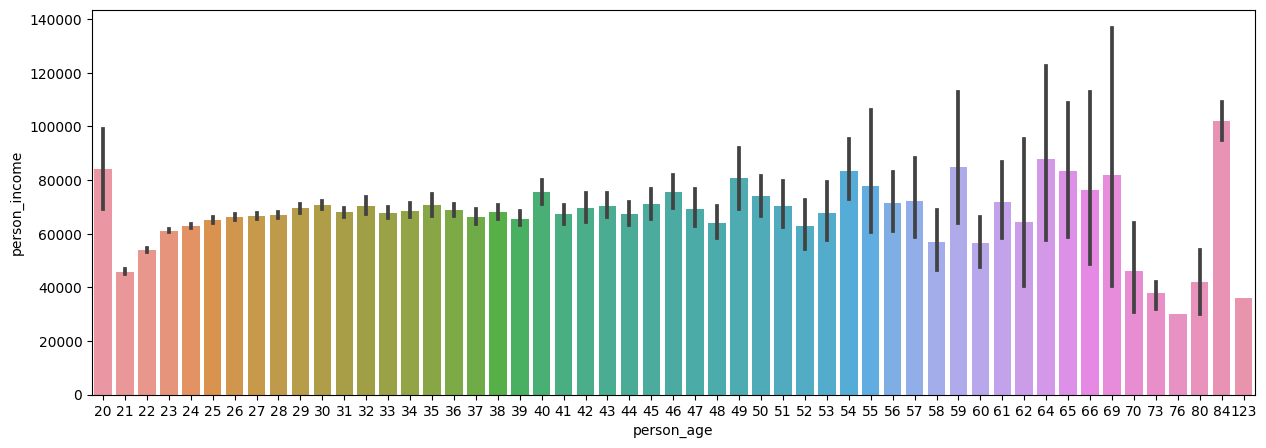

In [7]:
plt.figure(figsize=(15, 5))
sns.barplot(x=trn['person_age'], y=trn['person_income'])
plt.show()

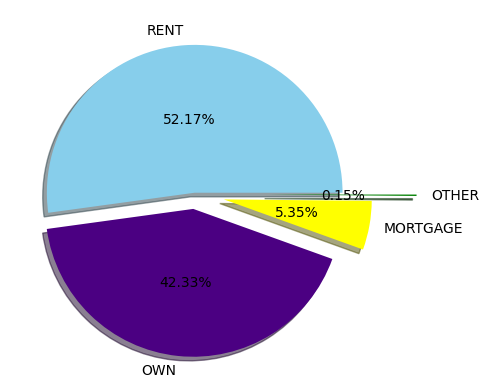

In [8]:
def pie_chat(data):
    plt.pie(data.value_counts(),
            labels=data.unique(),
            autopct='%.2f%%',
            shadow=True,
            pctdistance=0.5,
            colors=('skyblue', 'indigo', 'yellow', 'green'),
            explode=[0.01, 0.1, 0.2, 0.5])
    plt.show()
pie_chat(trn['person_home_ownership'])

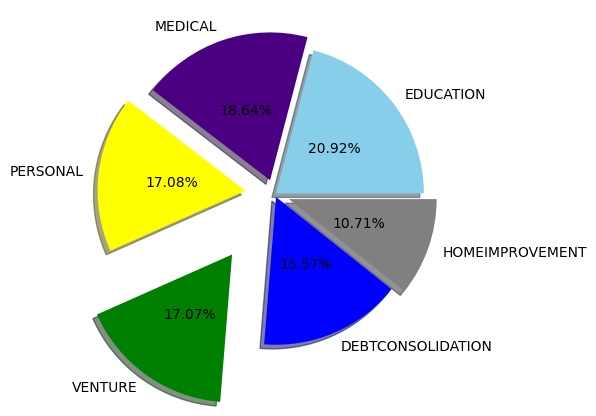

In [9]:
def pie_chat(data):
    plt.pie(data.value_counts(),
            labels=data.unique(),
            autopct='%.2f%%',
            shadow=True,
            pctdistance=0.5,
            colors=('skyblue', 'indigo', 'yellow', 'green', 'blue', 'grey'),
            explode=[0.01, 0.1, 0.2, 0.5, 0.02, 0.1])
    plt.show()
pie_chat(trn['loan_intent'])

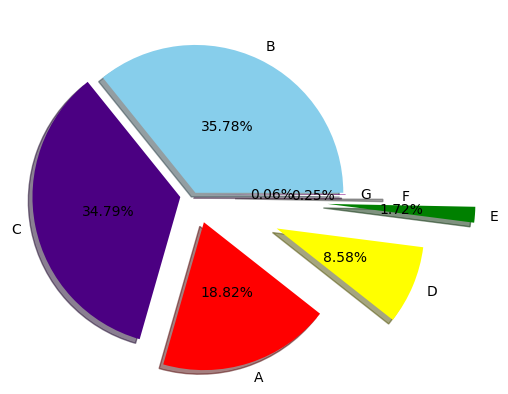

In [10]:
def pie_chat(data):
    plt.pie(data.value_counts(),
            labels=data.unique(),
            autopct='%.2f%%',
            shadow=True,
            pctdistance=0.5,
            colors=('skyblue', 'indigo', 'red', 'yellow', 'green', 'white', 'purple'),
            explode=[0.01, 0.1, 0.2, 0.6, 0.9, 0.3, 0.02])
    plt.show()
pie_chat(trn['loan_grade'])

***PREPROCESSING***

In [11]:
#categorical columns
cat_cols = trn.select_dtypes(include=['object'])
cat_cols.head(2)

,person_home_ownership,loan_intent,loan_grade,cb_person_default_on_file
0,RENT,EDUCATION,B,N
1,OWN,MEDICAL,C,N


In [12]:
num_cols = trn.select_dtypes(include=['int', 'float'])
num_cols.head(2)

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,loan_status
0,37,35000,0.0,6000,11.49,0.17,14,0
1,22,56000,6.0,4000,13.35,0.07,2,0


In [13]:
#this function encode the categorical columns
lab_enc = LabelEncoder()
def encoder(data):
    #encoding
    for col in data.columns:
        data[col] = lab_enc.fit_transform(data[col])
    return data.head(3)

encoder(cat_cols)

,person_home_ownership,loan_intent,loan_grade,cb_person_default_on_file
0,3,1,1,0
1,2,3,2,0
2,2,4,0,0


In [14]:
train = pd.concat([num_cols, cat_cols], axis=1)
train.head(2)

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,loan_status,person_home_ownership,loan_intent,loan_grade,cb_person_default_on_file
0,37,35000,0.0,6000,11.49,0.17,14,0,3,1,1,0
1,22,56000,6.0,4000,13.35,0.07,2,0,2,3,2,0


In [15]:
X = train.drop('loan_status', axis=1)
y = train.loan_status
X.head(2)

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,person_home_ownership,loan_intent,loan_grade,cb_person_default_on_file
0,37,35000,0.0,6000,11.49,0.17,14,3,1,1,0
1,22,56000,6.0,4000,13.35,0.07,2,2,3,2,0


In [16]:
#scalling
scaler = MinMaxScaler(feature_range=(0, 1))
X = pd.DataFrame(scaler.fit_transform(X))
X.head(2)

,0,1,2,3,4,5,6,7,8,9,10
0,0.165049,0.016246,0.00000,0.159420,0.341011,0.204819,0.428571,1.000000,0.2,0.166667,0.0
1,0.019417,0.027324,0.04878,0.101449,0.445506,0.084337,0.000000,0.666667,0.6,0.333333,0.0


In [17]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=10)
# Check shapes
for i in (X_train, X_val, y_train, y_val):
    print(list(i.shape))

[46916, 11]
[11729, 11]
[46916]
[11729]


***MODELS***

In [18]:
# Create LightGBM Datasets for training and validation 
train_data = lgb.Dataset(X_train, label=y_train) 
test_data = lgb.Dataset(X_val, label=y_val, reference=train_data) 
  
# Define hyperparameters and objective for LightGBM 
params = { 
    'objective': 'binary', 
    'metric': 'auc', 
    'boosting_type': 'gbdt', 
    'num_leaves': 31, 
    'learning_rate': 0.05, 
    'feature_fraction': 0.9,
    'random_state' : 10
} 

In [19]:
#rounds
num_round = 100
  
lgb_model = lgb.train(params, train_data, 
                  num_round, valid_sets=[test_data]) 

[LightGBM] [Info] Number of positive: 6709, number of negative: 40207
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008011 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 838
[LightGBM] [Info] Number of data points in the train set: 46916, number of used features: 11
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.143000 -> initscore=-1.790591
[LightGBM] [Info] Start training from score -1.790591


In [20]:
lgb_pred = lgb_model.predict(X_val)
score = roc_auc_score(y_val, lgb_pred)
print(f"Accuracy: {score:.2f}%")

Accuracy: 0.96%


***PREDICTION ON TEST***

In [21]:
#categorical columns
tst_cat_cols = tst.select_dtypes(include=['object'])
tst_cat_cols.head(2)

,person_home_ownership,loan_intent,loan_grade,cb_person_default_on_file
0,RENT,HOMEIMPROVEMENT,F,N
1,MORTGAGE,PERSONAL,C,Y


In [22]:
tst_num_cols = tst.select_dtypes(include=['int', 'float'])
tst_num_cols.head(2)

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length
0,23,69000,3.0,25000,15.76,0.36,2
1,26,96000,6.0,10000,12.68,0.10,4


In [23]:
encoder(tst_cat_cols)

,person_home_ownership,loan_intent,loan_grade,cb_person_default_on_file
0,3,2,5,0
1,0,4,2,1
2,3,5,4,1


In [24]:
X_test = pd.concat([tst_num_cols, tst_cat_cols], axis=1)
X_test.head(2)

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,person_home_ownership,loan_intent,loan_grade,cb_person_default_on_file
0,23,69000,3.0,25000,15.76,0.36,2,3,2,5,0
1,26,96000,6.0,10000,12.68,0.10,4,0,4,2,1


In [25]:
X_test = pd.DataFrame(scaler.fit_transform(X_test))
X_test.head(2)

,0,1,2,3,4,5,6,7,8,9,10
0,0.040541,0.034283,0.071429,0.708455,0.619533,0.493151,0.000000,1.0,0.4,0.833333,0.0
1,0.081081,0.048523,0.142857,0.271137,0.434991,0.136986,0.071429,0.0,0.8,0.333333,1.0


In [26]:
prediction = lgb_model.predict(X_test)
prediction

array([0.92754657, 0.02592764, 0.39392439, ..., 0.02410548, 0.30880972,
       0.94654226])

***SUBMISSION***

In [27]:
submission = subs
submission.head(2)

,id,loan_status
0,58645,0.5
1,58646,0.5


In [28]:
submission['loan_status'] = prediction.round(1)

In [29]:
submission.to_csv('submission.csv', index=False)